# Objective
We have been tasked with creating a machine learning (ML) model to predict the power output of a Combined Cycle Power Plant.

We've been given a data file with 9,568 observations of hourly readings of Temperature, Ambient Pressure, Relative Humidity, Exhaust Vacuum, and the power that was created during that hour.

Our final product will be an ML model that will be able to predict the power output given new observations of the readings mentioned above.

# Imports and Utilities

Imports

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from IPython.display import HTML

Classes

In [ ]:
models = []
class ModelPerformance:
  def __init__(self, name, mae_mean, mae_std, rmse_mean, rmse_std, r2_mean, r2_std):
    self.name = name
    self.mae_mean = round(mae_mean, 2)
    self.mae_std = round(mae_std, 2)
    self.rmse_mean = round(rmse_mean, 2)
    self.rmse_std = round(rmse_std, 2)
    self.r2_mean = round(r2_mean, 2)
    self.r2_std = round(r2_std, 2)
  def metrics(self):
    return {
        "Model": self.name,
        "RMSE_mean": self.rmse_mean,
        "RMSE_std": self.rmse_std,
        "MAE_mean": self.mae_mean,
        "MAE_std": self.mae_std,
        "R2_mean": self.r2_mean,
        "R2_std": self.r2_std
    }
  def metrics_string(self):
    plus_minus = " \u00B1 "
    print(f"Root Mean Squared Error: {self.rmse_mean}{plus_minus}{self.rmse_std}")
    print(f"Mean Average Error: {self.mae_mean}{plus_minus}{self.mae_std}")
    print(f"R Squared: {self.r2_mean}")


General Utilities

In [ ]:
FEATURE_MAP = {"AT": "Temperature", "AP": "Ambient Pressure",
               "RH": "Relative Humidity", "V": "Exhaust Vacuum"}
FEATURE_UNITS = {"AT": "C", "AP": "mbar", "RH": "%", "V": "cm Hg", "PE": "MW"}

def create_feature_v_pe_plot(feature: str):
  x = df[feature]
  y = df["PE"]
  # Create the line of best fit
  m, b = np.polyfit(x, y, 1)
  r = np.corrcoef(x,y)[0,1]
  plt.figure(figsize=(5,4))
  plt.scatter(x, y,
              alpha=.3, label=f"{feature} Data")
  plt.plot(x, m*x + b, color = "red", label = "Line of Best Fit")
  plt.text(.05, .05, f"R={r:.2f}", transform = plt.gca().transAxes,
           fontsize = 10, verticalalignment = "top")
  plt.title(f"{FEATURE_MAP[feature]} vs Power Output")
  plt.xlabel(FEATURE_UNITS[feature])
  plt.ylabel("MW")
  plt.legend()
  plt.show()

Model evaluation

In [ ]:
SCORING = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}
def evaluate_model(model_name, estimator, x, y, cv):
  results = cross_validate(estimator, x, y, cv=cv, scoring=SCORING, n_jobs=-1, return_estimator=False)
  rmse = -results["test_rmse"]
  mae = -results["test_mae"]
  r2 = results["test_r2"]
  return ModelPerformance(
      model_name, mae.mean(), mae.std(), rmse.mean(), rmse.std(), r2.mean(), r2.std())

# Load the Power Data


In [ ]:
# One approach is to add the data file to Google Drive and access it from there
# drive.mount('/content/drive')
# file_path = '/content/drive/{your_path}'
# df = pd.read_csv(file_path)

# Another approach is to upload the file manually
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('your_file.csv')

Mounted at /content/drive


# Validate File

In [ ]:
# Show the first few lines
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [ ]:
# Check the columns and validate there are no nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


# Visualizations
The plots below provide insight on the relationships between the variables. The plots will primarily focus on the relationships between Power Output (PE) and the other variables, because we aim to create an ML model to predict the Power Output.

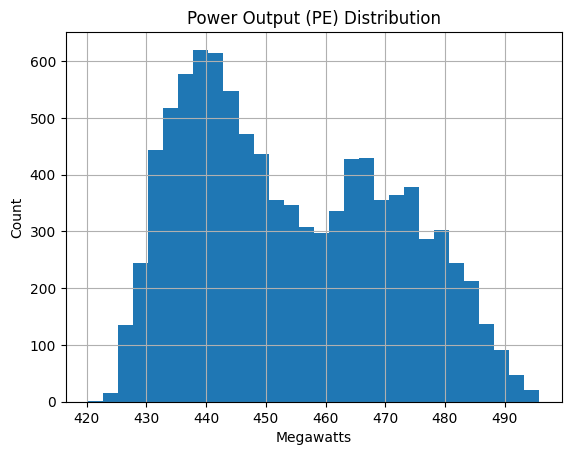

In [ ]:
df["PE"].hist(bins=30)
plt.title("Power Output (PE) Distribution")
plt.xlabel("Megawatts")
plt.ylabel("Count")
plt.show()

In [ ]:
# Measure correlation values, R, between our data columns
df.corr(numeric_only=True)

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


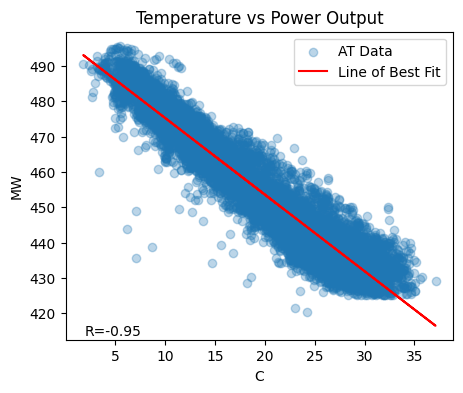

In [ ]:
# Create a plot of each feature against the power output (PE) that includes
# a line of best fit, and the R value.
create_feature_v_pe_plot("AT")


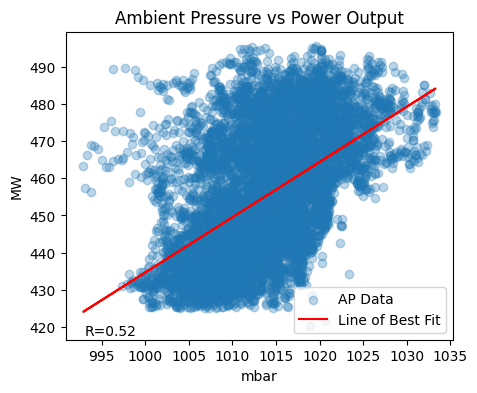

In [ ]:
create_feature_v_pe_plot("AP")

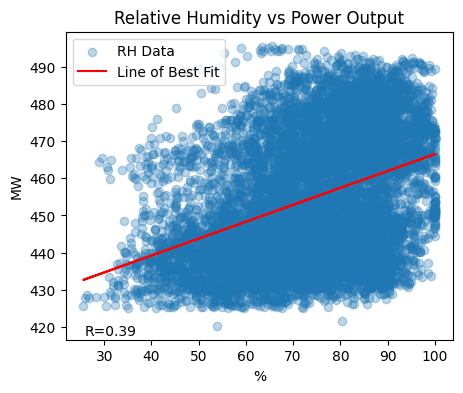

In [ ]:
create_feature_v_pe_plot("RH")

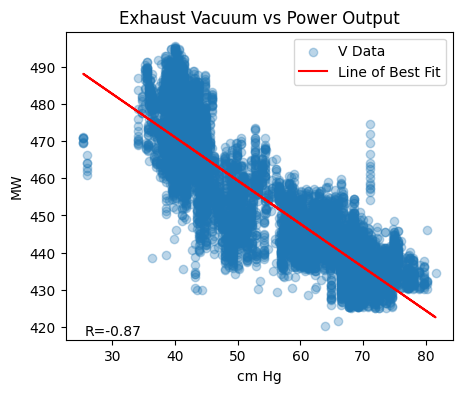

In [ ]:
create_feature_v_pe_plot("V")

# Prepare The Data
Before we start working on our models, we'll prepare the data. We will be employing the K-Folds validation technique. We'll split the data into five groups, so that each observation will be used eight times to train the model, and twice to test the model. As a result, our model's performance is not susceptible to the bias introduced by manually selecting a test set.

In [ ]:
columns = df.columns
# For the features, take all the columns except PE
x = df[columns[:4]]
# PE is the target
y = df[columns[-1]]

# Create 5 folds and repeat the process twice. Each test set will be
# 20% of the data
cv = RepeatedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

# Judging the Models
It's important to clearly establish how we will be judging the models we create so that the our choice is transparent and traceable.

We have determined that it's paramount that our model minimize large, outlier errors. Being badly off in our power output projections can lead to blackouts and reputational harm.

With that said, we will prioritize the Root Mean Squared Error (RMSE) metric. We will also look at the Mean Average Error (MAE) and $R^{2}$ values.

# Linear Regression
We'll start by creating a simple linear regression model. Linear regression models are always good baseline models.

In [ ]:
linear = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
linear_performance = evaluate_model("Linear Regression", linear, x, y, cv)
models.append(linear_performance)

In [ ]:
linear_performance.metrics_string()

Root Mean Squared Error: 4.56 ± 0.14
Mean Average Error: 3.63 ± 0.08
R Squared: 0.93


# Evaluation
The performance of our linear regression model is quite good.

Our root mean-squared error (RMSE) is 4.56, suggesting that a typical prediction is off by ~4.5 megawatts. Considering the range of observed power output being roughly between 420 and 500 MW, that's about a 1% error.

Our mean absolute error suggests that predictions deviate from observed values by an average of about 3.6 megawatts.

Our $R^{2}$ value of .93 indicates that our model explains 93% of the variance in power output.

# Next Steps
Let's see if we can create a model that performs better than our Linear Regression model. We'll create two more linear regression models that use regularization methods. We'll also create two degree 2 polynomial models that could identify some non-linearity. Finally, we'll create a random forest model which can identify threshold patterns and more thoroughly examine feature relationships.

# Linear Regression with Regularization

**Linear Regression with Ridge Regression**

Ridge regression can be helpful when there is collinearity, which we see between Temperature and Exhaust Vacuum (R = 0.84).

In [ ]:
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])
ridge_performance = evaluate_model("Linear Ridge", ridge, x, y, cv)
models.append(ridge_performance)

In [ ]:
ridge_performance.metrics_string()

Root Mean Squared Error: 4.56 ± 0.14
Mean Average Error: 3.63 ± 0.08
R Squared: 0.93


**Linear Regression With LASSO Regression**

Lasso regression can remove irrelevant features from the model.

In [ ]:
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=1.0, random_state=42))
])
lasso_performance = evaluate_model("Linear LASSO", lasso, x, y, cv)
models.append(lasso_performance)

In [ ]:
lasso_performance.metrics_string()

Root Mean Squared Error: 5.02 ± 0.1
Mean Average Error: 4.01 ± 0.06
R Squared: 0.91


# Polynomial Degree 2


In [ ]:
poly_deg2 = Pipeline([
  ("poly", PolynomialFeatures(degree=2, include_bias=False)),
  ("scaler", StandardScaler()),
  ("linreg", LinearRegression())
])
polynomial_performance = evaluate_model("Polynomial Deg 2", poly_deg2, x, y, cv)
models.append(polynomial_performance)

In [ ]:
polynomial_performance.metrics_string()

Root Mean Squared Error: 4.26 ± 0.16
Mean Average Error: 3.36 ± 0.08
R Squared: 0.94


# Polynomial Degree 2 With Ridge Regression

In [ ]:
poly_2ridge = Pipeline([
   ("poly", PolynomialFeatures(degree=2, include_bias = False)),
   # Scale polynomial-expanded features
   ("scaler", StandardScaler()),
   ("ridge", Ridge(alpha=1, random_state=42))
])
poly_ridge_performance = evaluate_model("Ridge Deg 2 Poly", poly_2ridge, x, y, cv)
models.append(poly_ridge_performance)

In [ ]:
poly_ridge_performance.metrics_string()

Root Mean Squared Error: 4.3 ± 0.15
Mean Average Error: 3.41 ± 0.07
R Squared: 0.94


# Random Forest

In [ ]:
forest = RandomForestRegressor(
    # Use 300 trees
    n_estimators = 300,
    random_state = 42,
    n_jobs = -1
)
forest_performance = evaluate_model("Random Forest", forest, x, y, cv)
models.append(forest_performance)

In [ ]:
forest_performance.metrics_string()

Root Mean Squared Error: 3.32 ± 0.15
Mean Average Error: 2.36 ± 0.05
R Squared: 0.96


# Metric Comparisons
Below we compare the mean RMSE, MAE, and $R^{2}$ values of each of the models.

In [ ]:
models = pd.DataFrame([model.metrics() for model in models]).sort_values("RMSE_mean")
HTML(models.to_html(index=False))

Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,R2_mean,R2_std
Random Forest,3.32,0.15,2.36,0.05,0.96,0.00
Polynomial Deg 2,4.26,0.16,3.36,0.08,0.94,0.01
Ridge Deg 2 Poly,4.30,0.15,3.41,0.07,0.94,0.00
Linear Regression,4.56,0.14,3.63,0.08,0.93,0.00
Linear Ridge,4.56,0.14,3.63,0.08,0.93,0.00
Linear LASSO,5.02,0.10,4.01,0.06,0.91,0.00


# Evaluation and Final Selection
As we can see above, the Random Forest model reduces RMSE by 22% compared to the next best model. The Random Forest model also has a smaller MAE mean and a better $R^{2}$ value. Our Random Forest model accounts for 96% of the variability in the Power Output.

With that said, we will select our Random Forest model.

One drawback of this choice is that Random Forest models are less interpretable than simpler models such as linear regression.

# Forest Example
Below is an example Random Forest model. We plot the model's predictions against the actual values and include a red line to represent what perfect predictions would look like. As we can see, the points are clustered closely around the line. We also look at the importance of the features to the model.

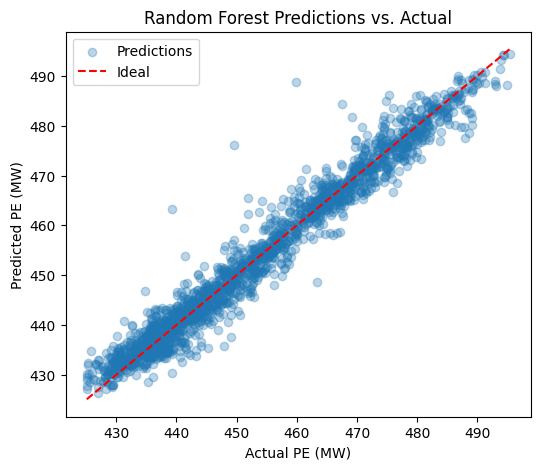

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)
forest_ex = RandomForestRegressor(
    n_estimators = 300,
    random_state = 42,
    n_jobs = -1
)
forest_ex.fit(x_train, y_train)
y_hat_forest = forest_ex.predict(x_test)
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_hat_forest, alpha=.3, label="Predictions")
low = np.min([y_test.min(), y_hat_forest.min()])
high = np.max([y_test.max(), y_hat_forest.max()])
plt.plot([low, high], [low, high], "r--", label="Ideal")
plt.title("Random Forest Predictions vs. Actual")
plt.xlabel("Actual PE (MW)")
plt.ylabel("Predicted PE (MW)")
plt.legend()
plt.show()

In [ ]:
pd.Series(forest_ex.feature_importances_, index=x_train.columns).sort_values(
    ascending=False
)

,0
AT,0.901707
V,0.061622
AP,0.018573
RH,0.018098


Temperature is the most important feature to our random forest model.